# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования:**
1. Определить рыночную стоимость объектов недвижимости.
2. Построить автоматизированную систему, которая отследит аномалии и мошенническую деятельность.
3. Установить, какие факторы влияют на ценообразование стоимости квартир.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


 Что мы видим? В таблице куча колонок, встречаются все типы данных: целые числа, дробные, булевы значения, текст. Много пропусков - примерно в половине столбцов, и с каждым надо разбираться отдельно

Чтобы яснее понять общую картину по базе построим гистограммы на каждый столбец. Гистограмм не будет только на колонки с булевыми значениями и текстом.

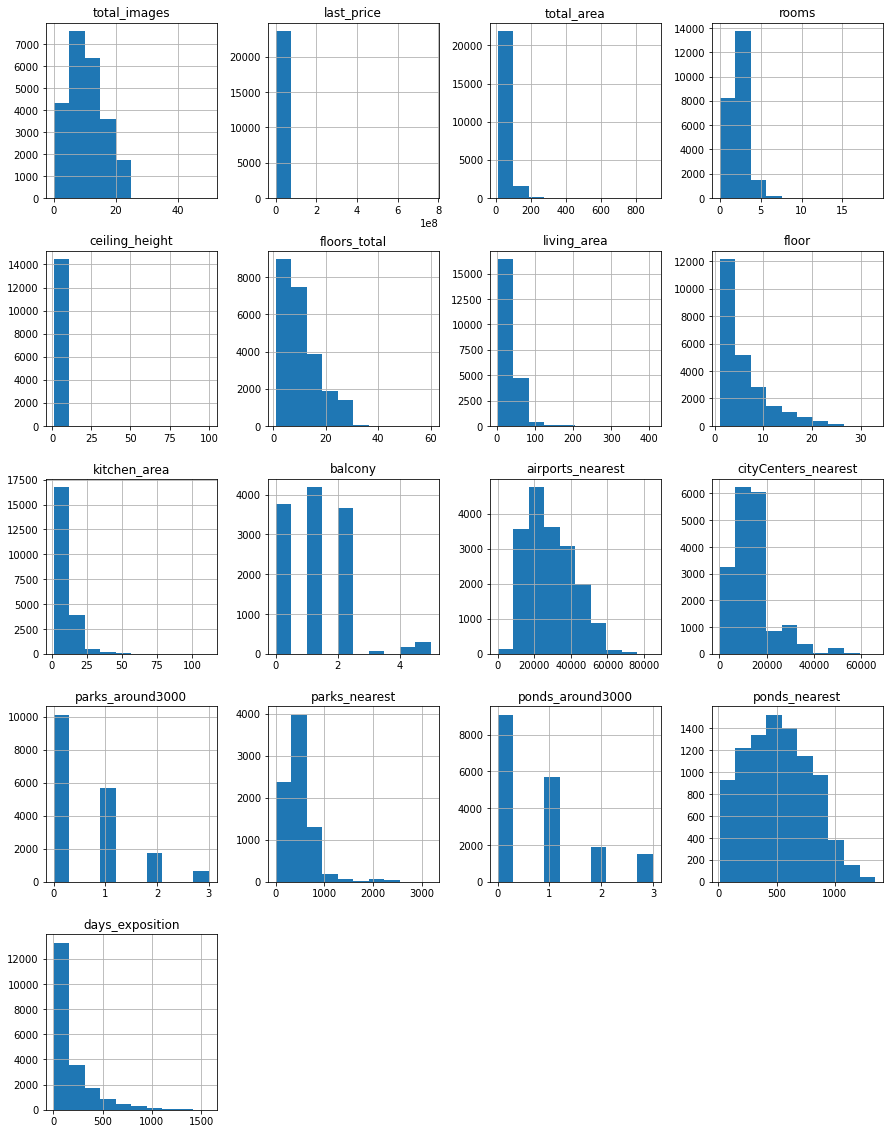

In [2]:
import matplotlib.pyplot as plt
data.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

Найдем и изучим пропущенные значения в столбцах

In [3]:
data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

**Изучим столбец 'is_apartment'.** Там больше всего пропусков: 20924 из 23699. И если в пропусках стоит NaN, посмотрим, что же стоит там где нет пропуска.

In [4]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Оказывается это булев столбец. И надо решить, что делать с пропусками. Очевидно, что удалять нельзя, потеряем почти все данные.
Если заменить NaN на 'unknown', то тип столбца на булев мы поменять не сможем. Как понять, апарт в строке или нет... 
Думаю, логично будет предположить, что отсутствие данных = False, т.к. апартов пока на рынке явно меньше, нежели квартир. Поэтому заменим пропуски и поменяем тип данных.

In [5]:
# Если сразу применить astype, то пропуски NaN заменятся на True, поэтому обойдем эту неприятность таким вот образом
data['is_apartment'] = data['is_apartment'].fillna(0)
data['is_apartment'] = data['is_apartment'].astype('bool')
# Проверим себя
print(data['is_apartment'].unique())
print(data['is_apartment'].dtype)
data.head()


[False  True]
bool


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Изучим столбцы 'parks_nearest' и 'ponds_nearest**

In [6]:
data['parks_nearest'].sort_values(ascending=False)

10959    3190.0
19430    3190.0
1590     3064.0
19208    3013.0
23080    2984.0
          ...  
23691       NaN
23692       NaN
23695       NaN
23696       NaN
23698       NaN
Name: parks_nearest, Length: 23699, dtype: float64

In [7]:
data['ponds_nearest'].sort_values(ascending=False)

20726    1344.0
19924    1341.0
19138    1341.0
1476     1337.0
12054    1313.0
          ...  
23690       NaN
23692       NaN
23695       NaN
23696       NaN
23698       NaN
Name: ponds_nearest, Length: 23699, dtype: float64

В обоих колонках больше половины значений с пропусками. Причина пропусков возможно в отсутствии рядом и парка и пруда. Самое большое значение для парка 3190 метров, для пруда - 1344 метра. Это кстати примерно 40 мин / 20 мин пешком. Видимо дальше по удаленности указывать нет смысла. Предлагаю поставить нули вместо пропусков.

Тип колонок вещественные (дробные) числа, расстояние в метрах до парка/пруда. Даже если внутри данных есть дробные числа, нам точность до сантиметров не нужна, - преобразуем колонки в целые числа.

In [8]:
data['parks_nearest'] = data['parks_nearest'].fillna(0).astype('int')
data['ponds_nearest'] = data['ponds_nearest'].fillna(0).astype('int')
# проверим, что получилось
print(data['parks_nearest'].isna().sum())
print(data['parks_nearest'].dtype)
print(data['ponds_nearest'].isna().sum())
print(data['ponds_nearest'].dtype)

0
int64
0
int64


**Разберемся с балконами**

В колонке больше 11 тыс пропусков. Однако если продавец не указал число балконов, то, скорее всего, в квартире их нет. Такие пропуски правильно заменить на 0.

И поменяем тип данных с float на int, ведь не может же быть 1,5 балкона...

In [9]:
data['balcony'] = data['balcony'].fillna(0).astype('int')

In [10]:
# посмотрим и посчитаем уникальные значения
data['balcony'].value_counts()

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

Очень странно, в нашей стране я не встречала квартиры больше, чем с двумя балконами. Погуглила, нашла эксклюзивный вариант с 3 балконами в одном загородном ЖК, и все. Думаю, что объекты с 3, 4 и 5 балконами можно удалить из базы как недостоверные.

In [11]:
data = data.query('balcony < 3')

**ceiling_height** float  9195 пропусков


In [12]:
data['ceiling_height'].unique()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  3.2 ,  2.61,  3.25,  3.45,
        2.77,  2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,
        2.47,  2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,
        2.51,  2.78,  2.76, 25.  ,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,
        2.66,  2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,
        3.15,  3.55,  3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,
        5.3 ,  5.  ,  2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,
        2.83,  4.7 ,  2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,
        3.35,  2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,
        3.52,  3.95,  3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,
        4.19,  3.24,  4.8 ,  4.5 ,  4.2 ,  3.36, 32.  ,  3.08,  3.68,
        3.07,  3.37,  3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,
        3.14,  4.37,  2.68,  3.22,  3.27, 27.  ,  4.1 ,  2.93,  3.46,
       24.  ,  3.47,

Что-то слишком много для высоты потолков уникальных значений... Глаза разбегаются...

Предлагаю уменьшить их количество округлением до десятых.

In [13]:
data['ceiling_height'] = data['ceiling_height'].round(1)
data['ceiling_height'].unique()

array([ 2.7,  nan,  3. ,  2.5,  2.6,  2.8,  2.9,  3.2,  3.4,  4.2,  3.5,
        3.3,  4. ,  3.1,  2.3, 25. ,  3.7,  5.2,  2. ,  2.4,  3.6,  3.8,
        5.3,  5. ,  4.1,  4.7,  5.6,  3.9,  4.8,  4.5, 32. ,  8. ,  4.4,
       27. , 24. , 26. ,  1.2,  8.3,  5.5,  4.3,  4.6,  2.2, 14. ,  1.8,
        6. , 22.6,  5.8, 27.5,  4.9, 10.3,  1. ])

О! уже лучше! Кстати, потолков меньше 2,5 м и больше 5 м (для двухуровневых квартир) я не встречала. 

Нет ли явных опечаток среди выбросов?

25.  -- это скорее всего 2,5

32.  -- 3,2

27.5 -- 2,75 или с округлением до десятых 2,8

26. -- 2,6

27. -- 2,7

Заменим их

In [14]:
data['ceiling_height'] = data['ceiling_height'].replace({25. :2.5, 32. :3.2, 27.5:2.8, 26. :2.6, 27. :2.7})
data['ceiling_height'].value_counts()

2.5     3731
2.6     3623
2.8     2140
2.7     1710
3.0     1184
3.2      400
3.1      275
2.9      206
3.3      176
3.5      154
3.4      138
3.6       72
4.0       48
3.7       37
3.8       36
2.4       34
3.9       19
4.2       14
2.0       11
4.5        7
4.4        6
4.1        5
2.3        5
8.0        3
4.7        2
5.3        2
2.2        2
4.3        1
8.3        1
1.0        1
5.6        1
1.8        1
5.0        1
6.0        1
5.5        1
4.6        1
4.8        1
10.3       1
24.0       1
14.0       1
22.6       1
4.9        1
5.2        1
5.8        1
1.2        1
Name: ceiling_height, dtype: int64

После замены аномалий, вернемся к пропускам. В данном случае логично заменить их средним значением

In [15]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].mean().round(1))
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482,2.0,755,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.7,11.0,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,0,0.0,0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.7,5.0,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90,2.0,574,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.7,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84,3.0,234,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.0,14.0,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112,1.0,48,121.0


In [16]:
# оставшихся аномальных значений, которые меньше 2,5 и больше 5м - совсем не много, можно спокойно их удалить
data = data.query('2.5 <= ceiling_height <= 5.0')
data['ceiling_height'].unique()

array([2.7, 3. , 2.5, 2.6, 2.8, 2.9, 3.2, 3.4, 4.2, 3.5, 3.3, 4. , 3.1,
       3.7, 3.6, 3.8, 5. , 4.1, 4.7, 3.9, 4.8, 4.5, 4.4, 4.3, 4.6, 4.9])

**airports_nearest** float  5542 пропуска

In [17]:
data['airports_nearest'].describe()

count    17667.000000
mean     28760.326881
std      12637.881262
min          0.000000
25%      18574.500000
50%      26609.000000
75%      37227.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Разброс очень большой, от 0 до 85 км, причем 2/3 квартир находятся не далее 37 км от аэропорта.

Пропуски составляют 23% данных, удалять жалко. Предполагаю, что причина пропусков - областная локация. Поэтому большинству покупателей этот параметр не так уж и важен, или это далеко настолько, что не потрудились посчитать. Проверим предположение.

In [18]:
data[data['airports_nearest'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.7,12.0,14.40,5,False,...,9.10,0,городской посёлок Янино-1,NaN,NaN,NaN,0,NaN,0,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.7,27.0,15.43,26,False,...,8.81,0,посёлок Мурино,NaN,NaN,NaN,0,NaN,0,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.7,5.0,30.00,5,False,...,9.00,0,Сертолово,NaN,NaN,NaN,0,NaN,0,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.8,25.0,30.00,15,False,...,11.00,2,деревня Кудрово,NaN,NaN,NaN,0,NaN,0,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.7,9.0,NaN,2,False,...,NaN,0,Коммунар,NaN,NaN,NaN,0,NaN,0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.5,5.0,45.50,3,False,...,5.50,0,посёлок Дзержинского,NaN,NaN,NaN,0,NaN,0,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.7,5.0,17.50,4,False,...,6.00,0,Тихвин,NaN,NaN,NaN,0,NaN,0,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.7,5.0,38.00,4,False,...,8.50,0,Тосно,NaN,NaN,NaN,0,NaN,0,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.7,3.0,29.70,1,False,...,NaN,0,село Рождествено,NaN,NaN,NaN,0,NaN,0,NaN


Так и есть! Предлагаю оставить пропуски как есть, и не заполнять не медианой, ни средним, это будет недостоверно.

**cityCenters_nearest**    float  5519 пропусков

In [19]:
data['cityCenters_nearest'].describe()

count    17690.000000
mean     14174.115941
std       8624.148356
min        181.000000
25%       9184.000000
50%      13094.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Картина аналогичная ситуации с аэропортом, - большой разброс данных, и 23% исходной выборки - пропуски.

Это как чемодан без ручки - нести тяжело и выкинуть жалко.

Причина пропусков думаю похожа. Если указана локация, особенно, если это область, и так понятно что до центра города далеко, собственники не заморачиваются подсчетами и не заполняют эту колонку. Проверим это.

In [20]:
data[data['cityCenters_nearest'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.7,12.0,14.40,5,False,...,9.10,0,городской посёлок Янино-1,NaN,NaN,NaN,0,NaN,0,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.7,27.0,15.43,26,False,...,8.81,0,посёлок Мурино,NaN,NaN,NaN,0,NaN,0,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.7,5.0,30.00,5,False,...,9.00,0,Сертолово,NaN,NaN,NaN,0,NaN,0,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.8,25.0,30.00,15,False,...,11.00,2,деревня Кудрово,NaN,NaN,NaN,0,NaN,0,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.7,9.0,NaN,2,False,...,NaN,0,Коммунар,NaN,NaN,NaN,0,NaN,0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.5,5.0,45.50,3,False,...,5.50,0,посёлок Дзержинского,NaN,NaN,NaN,0,NaN,0,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.7,5.0,17.50,4,False,...,6.00,0,Тихвин,NaN,NaN,NaN,0,NaN,0,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.7,5.0,38.00,4,False,...,8.50,0,Тосно,NaN,NaN,NaN,0,NaN,0,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.7,3.0,29.70,1,False,...,NaN,0,село Рождествено,NaN,NaN,NaN,0,NaN,0,NaN


Ну вот, так оно и есть!

Поэтому как и в случае с удаленностью от аэропорта, предлагаю оставить пропуски в покое.

**ponds_around3000**    float     5518 пропусков

**parks_around3000**    float     5518 пропусков

In [21]:
data['ponds_around3000'].value_counts()

0.0    8822
1.0    5568
2.0    1847
3.0    1454
Name: ponds_around3000, dtype: int64

In [22]:
data['parks_around3000'].value_counts()

0.0    9861
1.0    5499
2.0    1699
3.0     632
Name: parks_around3000, dtype: int64

Причина пропусков думаю отсутствие поблизости прудов и парков, и можно смело заполнять пропуски нулями. А тип данных изменить на 'int'

In [23]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23061 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23061 non-null  int64  
 1   last_price            23061 non-null  float64
 2   total_area            23061 non-null  float64
 3   first_day_exposition  23061 non-null  object 
 4   rooms                 23061 non-null  int64  
 5   ceiling_height        23061 non-null  float64
 6   floors_total          22975 non-null  float64
 7   living_area           21199 non-null  float64
 8   floor                 23061 non-null  int64  
 9   is_apartment          23061 non-null  bool   
 10  studio                23061 non-null  bool   
 11  open_plan             23061 non-null  bool   
 12  kitchen_area          20811 non-null  float64
 13  balcony               23061 non-null  int64  
 14  locality_name         23013 non-null  object 
 15  airports_nearest   

**days_exposition**    float      3181 пропусков

In [24]:
data['days_exposition'].describe()

count    19999.000000
mean       180.748287
std        219.815431
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1572.000000
Name: days_exposition, dtype: float64

макс значение - 1572 дня в продаже это 4,3 года! Я работаю в агентстве недвижимости, и могу сказать, что живые объявления столько в продаже не висят. Даже при изначально завышенной цене - не более двух лет, это прям максимум. Потом или снятие с продажи вообще, или замена другим объявлением.
Чтобы в этом убедиться наглядно, построим диаграмму размаха. Хотя и по describe() видно, межвартильный размах  45 - 231 день, т.е. основная масса объявлений о продаже висит в рекламе от 1,5 мес до 7,5 мес.

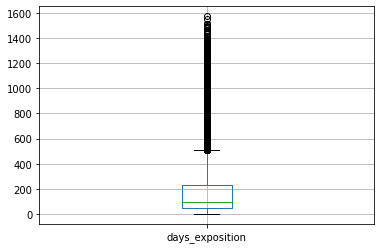

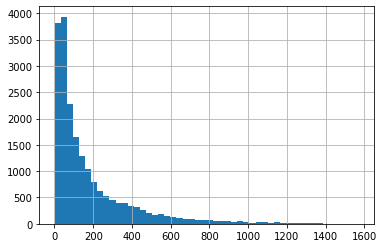

In [25]:
data.boxplot(column='days_exposition')
plt.show()
data['days_exposition'].hist(bins=50)
plt.show()

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Здорово, что  проверяешь данные не "на глаз". Лучше посмотреть на выбросы и аномалии данных математически, и удалить их с помощью специального метода boxplot() 

Гистограмма похожа на распределение Пуасона, данные выглядять вполне достоверными.

Сейчас mean=181  median=95

Я предлагаю не перезаписывая данные (иначе потеряем пропуски) попробовать отсечь хвост выбросов за пределами верхнего уса диаграммы размаха. (231-45)*1.5+231 = 510

И заново посмотреть описание данных столбца, а именно как изменились среднее и медиана.

In [26]:
data.query('days_exposition < 511').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,18359.000000,1.835900e+04,18359.000000,18359.00000,18359.000000,18289.000000,16776.000000,18359.000000,16426.000000,18359.000000,14151.000000,14170.000000,18359.000000,18359.000000,18359.000000,18359.000000,18359.000000
mean,9.654393,6.002465e+06,57.333322,1.98257,2.709630,10.888075,32.622294,5.988398,10.256657,0.509832,28905.527383,14432.874665,0.453892,162.494907,0.573506,199.527371,128.275451
std,5.638790,1.035129e+07,32.580187,1.03091,0.196638,6.669282,20.454624,4.942410,5.440118,0.759727,12808.321262,8465.448606,0.736380,302.501514,0.865398,306.794902,121.089857
min,0.000000,1.219000e+04,12.000000,0.00000,2.500000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,208.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,3.350000e+06,39.000000,1.00000,2.600000,5.000000,18.000000,2.000000,7.000000,0.000000,18428.000000,9779.500000,0.000000,0.000000,0.000000,0.000000,41.000000
50%,9.000000,4.450000e+06,50.000000,2.00000,2.700000,9.000000,29.400000,4.000000,9.000000,0.000000,26902.000000,13268.000000,0.000000,0.000000,0.000000,0.000000,85.000000
75%,14.000000,6.300000e+06,66.000000,3.00000,2.700000,16.000000,40.000000,8.000000,11.500000,1.000000,37434.000000,16453.000000,1.000000,284.000000,1.000000,392.000000,182.000000
max,50.000000,7.630000e+08,900.000000,19.00000,5.000000,60.000000,409.700000,33.000000,112.000000,2.000000,83758.000000,64857.000000,3.000000,3190.000000,3.000000,1344.000000,510.000000


Теперь mean=128 median=85

За счет игнорирования выбросов они существенно сблизились, выборка стала однороднее.

Считаю правильным заменить пропуски на среднее 128. Чуть больше 4 мес это наиболее вероятный (по опыту) срок продажи квартиры в городе-милионнике при прочих равных условиях.

In [27]:
# заменим пропуски и поменяем тип данных
data['days_exposition'] = data['days_exposition'].fillna(128).astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23061 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23061 non-null  int64  
 1   last_price            23061 non-null  float64
 2   total_area            23061 non-null  float64
 3   first_day_exposition  23061 non-null  object 
 4   rooms                 23061 non-null  int64  
 5   ceiling_height        23061 non-null  float64
 6   floors_total          22975 non-null  float64
 7   living_area           21199 non-null  float64
 8   floor                 23061 non-null  int64  
 9   is_apartment          23061 non-null  bool   
 10  studio                23061 non-null  bool   
 11  open_plan             23061 non-null  bool   
 12  kitchen_area          20811 non-null  float64
 13  balcony               23061 non-null  int64  
 14  locality_name         23013 non-null  object 
 15  airports_nearest   

In [28]:
# теперь до конца отрежем хвост выбросов
data = data.query('days_exposition < 511')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21421 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21421 non-null  int64  
 1   last_price            21421 non-null  float64
 2   total_area            21421 non-null  float64
 3   first_day_exposition  21421 non-null  object 
 4   rooms                 21421 non-null  int64  
 5   ceiling_height        21421 non-null  float64
 6   floors_total          21342 non-null  float64
 7   living_area           19648 non-null  float64
 8   floor                 21421 non-null  int64  
 9   is_apartment          21421 non-null  bool   
 10  studio                21421 non-null  bool   
 11  open_plan             21421 non-null  bool   
 12  kitchen_area          19289 non-null  float64
 13  balcony               21421 non-null  int64  
 14  locality_name         21378 non-null  object 
 15  airports_nearest   

**kitchen_area**     float        2278 пропусков

**living_area**    float          1903 пропусков

Исследуем причину пропусков

In [29]:
data.query('kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.7,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84,3,234,424
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.7,9.0,NaN,2,False,...,NaN,0,Коммунар,NaN,NaN,0,0,0,0,63
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.5,5.0,NaN,1,False,...,NaN,0,поселок городского типа Красный Бор,NaN,NaN,0,0,0,0,196
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.7,22.0,NaN,3,False,...,NaN,1,Санкт-Петербург,30471.0,11603.0,1,620,1,1152,128
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.7,13.0,NaN,13,False,...,NaN,0,Санкт-Петербург,11125.0,14501.0,0,0,0,0,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23642,14,5950000.0,80.3,2018-07-03T00:00:00,3,2.7,12.0,NaN,5,False,...,NaN,0,Колпино,27933.0,33719.0,0,0,2,562,60
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.6,10.0,NaN,1,False,...,NaN,0,Санкт-Петербург,33642.0,13943.0,0,0,2,844,59
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.8,9.0,NaN,2,False,...,NaN,0,поселок городского типа Синявино,NaN,NaN,0,0,0,0,45
23679,0,2500000.0,35.0,2017-12-08T00:00:00,1,2.7,9.0,NaN,4,False,...,NaN,0,Сосновый Бор,NaN,NaN,0,0,0,0,45


Пропуски в kitchen_area кажется дублируют пропуски в living_area, airports_nearest,	cityCenters_nearest. Остальные колонки выглядят вполне адекватно, но возможно потому, что пропуски в них мы уже заполнили. Тем не менее проверим это наше предположение

In [30]:
data.query('kitchen_area.isna()' or 'living_area.isna()' or 'airports_nearest.isna()' or 'cityCenters_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.7,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84,3,234,424
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.7,9.0,NaN,2,False,...,NaN,0,Коммунар,NaN,NaN,0,0,0,0,63
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.5,5.0,NaN,1,False,...,NaN,0,поселок городского типа Красный Бор,NaN,NaN,0,0,0,0,196
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.7,22.0,NaN,3,False,...,NaN,1,Санкт-Петербург,30471.0,11603.0,1,620,1,1152,128
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.7,13.0,NaN,13,False,...,NaN,0,Санкт-Петербург,11125.0,14501.0,0,0,0,0,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23642,14,5950000.0,80.3,2018-07-03T00:00:00,3,2.7,12.0,NaN,5,False,...,NaN,0,Колпино,27933.0,33719.0,0,0,2,562,60
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.6,10.0,NaN,1,False,...,NaN,0,Санкт-Петербург,33642.0,13943.0,0,0,2,844,59
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.8,9.0,NaN,2,False,...,NaN,0,поселок городского типа Синявино,NaN,NaN,0,0,0,0,45
23679,0,2500000.0,35.0,2017-12-08T00:00:00,1,2.7,9.0,NaN,4,False,...,NaN,0,Сосновый Бор,NaN,NaN,0,0,0,0,45


Пропуски в kitchen_area дублируют пропуски в living_area. На саботаж при заполнении непохоже, ведь площадь - важнейшая из характеристик при купле-продаже. Тем более тут еще такое дублирование пропусков столбцах. Похоже на технический сбой при выгрузке данных. 

Удалять нельзя, надо чем-то заполнять.

Изучим данные в столбцах.

In [31]:
data['kitchen_area'].describe()

count    19289.000000
mean        10.413272
std          5.702762
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64

In [32]:
data['living_area'].describe()

count    19648.000000
mean        33.692210
std         21.399254
min          2.000000
25%         18.400000
50%         30.000000
75%         41.900000
max        409.700000
Name: living_area, dtype: float64

Вы видели кухню 1,3 кв.м. или 112 кв.м., а жилую площадь 2 кв.м.? я нет...

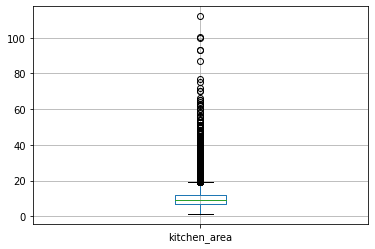

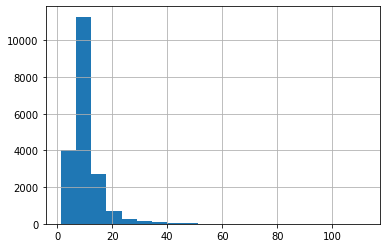

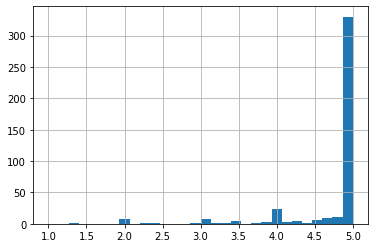

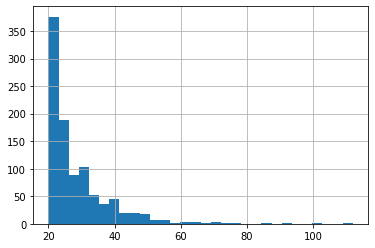

In [33]:
data.boxplot(column='kitchen_area')
plt.show()
data['kitchen_area'].hist(bins=20)
plt.show()
# сделаем по краям покрупнее
data['kitchen_area'].hist(bins=30, range=(1, 5))
plt.show()
data['kitchen_area'].hist(bins=30, range=(20, 112))
plt.show()

Предлагаю заполнить пропуски медианным значением, а потом отрезать хвост выбросов до 4 и больше 20.

In [34]:
# по экспериментируем, не перезаписывая
data.query('4 <= kitchen_area <=20').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,18401.000000,1.840100e+04,18401.000000,18401.000000,18401.000000,18370.000000,18057.000000,18401.000000,18401.000000,18401.000000,14113.000000,14130.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000
mean,10.006956,5.562839e+06,56.286138,2.009565,2.705695,10.600381,32.482172,5.827183,9.521869,0.535351,28856.351378,14589.867587,0.446932,160.841096,0.558339,196.478670,129.767621
std,5.590720,4.837729e+06,25.650481,0.979472,0.199020,6.526042,17.472704,4.812780,3.203963,0.766601,12849.712874,8556.522480,0.726458,297.441687,0.855533,306.006765,112.633592
min,0.000000,4.300000e+05,20.000000,1.000000,2.500000,1.000000,2.000000,1.000000,4.000000,0.000000,0.000000,181.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,3.400000e+06,39.900000,1.000000,2.600000,5.000000,18.330000,2.000000,7.000000,0.000000,18277.000000,10006.250000,0.000000,0.000000,0.000000,0.000000,45.000000
50%,10.000000,4.500000e+06,50.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26835.000000,13322.500000,0.000000,0.000000,0.000000,0.000000,112.000000
75%,14.000000,6.300000e+06,65.600000,3.000000,2.700000,15.000000,41.000000,8.000000,11.000000,1.000000,37434.000000,16463.250000,1.000000,286.000000,1.000000,382.000000,164.000000
max,50.000000,1.599840e+08,631.200000,14.000000,4.800000,60.000000,322.300000,33.000000,20.000000,2.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,1344.000000,510.000000


Медиана и средняя почти сравнялись - это круто! данные после отрезания выбросов станут супер-равномерными.

Для замены пропусков возьмем медиану 9. 

Кстати, могли и не заморачиваться, медиана без изменений, а вот средняя подвинулась поближе к медиане.

In [35]:
# заполняем пропуски и отрезаем хвосты
data['kitchen_area'] = data['kitchen_area'].fillna(9)
data = data.query('4 <= kitchen_area <=20')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20533 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20533 non-null  int64  
 1   last_price            20533 non-null  float64
 2   total_area            20533 non-null  float64
 3   first_day_exposition  20533 non-null  object 
 4   rooms                 20533 non-null  int64  
 5   ceiling_height        20533 non-null  float64
 6   floors_total          20458 non-null  float64
 7   living_area           18800 non-null  float64
 8   floor                 20533 non-null  int64  
 9   is_apartment          20533 non-null  bool   
 10  studio                20533 non-null  bool   
 11  open_plan             20533 non-null  bool   
 12  kitchen_area          20533 non-null  float64
 13  balcony               20533 non-null  int64  
 14  locality_name         20495 non-null  object 
 15  airports_nearest   

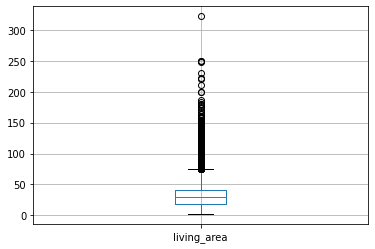

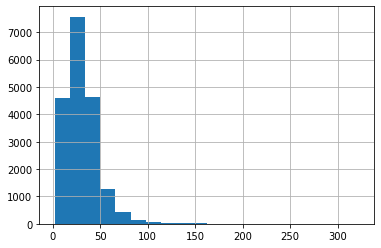

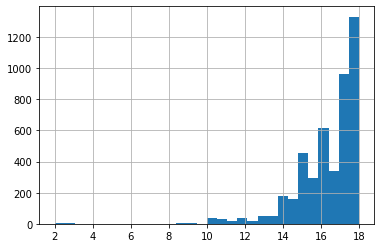

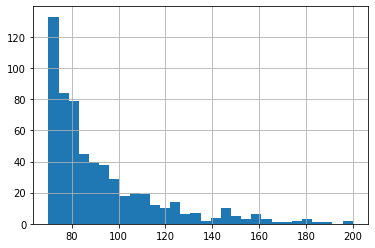

In [36]:
data.boxplot(column='living_area')
plt.show()
data['living_area'].hist(bins=20)
plt.show()
# сделаем по краям покрупнее
data['living_area'].hist(bins=30, range=(2, 18))
plt.show()
data['living_area'].hist(bins=30, range=(70, 200))
plt.show()

Также как и с площадью кухни предлагаю заполнить пропуски медианным значением 30, а потом отрезать хвост выбросов до 10 кв.м. и больше 150 кв.м.

In [37]:
# заполняем пропуски и отрезаем хвосты
data['living_area'] = data['living_area'].fillna(30)
data = data.query('10 <= living_area <=150')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20481 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20481 non-null  int64  
 1   last_price            20481 non-null  float64
 2   total_area            20481 non-null  float64
 3   first_day_exposition  20481 non-null  object 
 4   rooms                 20481 non-null  int64  
 5   ceiling_height        20481 non-null  float64
 6   floors_total          20406 non-null  float64
 7   living_area           20481 non-null  float64
 8   floor                 20481 non-null  int64  
 9   is_apartment          20481 non-null  bool   
 10  studio                20481 non-null  bool   
 11  open_plan             20481 non-null  bool   
 12  kitchen_area          20481 non-null  float64
 13  balcony               20481 non-null  int64  
 14  locality_name         20443 non-null  object 
 15  airports_nearest   

**floors_total**   float            86 пропусков

In [38]:
data['floors_total'].value_counts()

5.0     5075
9.0     3412
12.0    1207
16.0    1192
10.0     995
4.0      990
25.0     922
17.0     731
6.0      686
3.0      577
14.0     489
7.0      461
18.0     435
24.0     408
2.0      344
15.0     311
23.0     310
19.0     301
8.0      281
22.0     245
20.0     212
13.0     185
11.0     166
27.0     156
21.0     138
26.0     115
28.0      20
1.0       20
35.0      16
36.0       2
34.0       1
60.0       1
29.0       1
52.0       1
Name: floors_total, dtype: int64

35 этажей и выше вызывают у меня сомнения. Не помню, чтобы в Питере и его окрестностях строили аналог Москва-сити. Обрежем!

А пропуски, их мало, всего 86. Присваивать им среднюю или медиану бессмысленно, ведь часто этажность дома является критерием выбора квартиры. Можно посмотреть на каком этаже эти квартиры с пропусками, может что-то прояснится.


In [39]:
data.loc[data['floors_total'].isna(), 'floor']

186       4
237       1
671       8
1757      9
1930      4
         ..
20738    10
21651    19
21753    21
22656    20
23658     8
Name: floor, Length: 75, dtype: int64

Не вижу никакой зависимости, придется оставить эти 86 пропусков в покое. 

И тип данных тогда на int изменить не удастся, ну и ладно.

In [40]:
# обрезаем хвост выбросов
data = data.query('floors_total < 35')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20386 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20386 non-null  int64  
 1   last_price            20386 non-null  float64
 2   total_area            20386 non-null  float64
 3   first_day_exposition  20386 non-null  object 
 4   rooms                 20386 non-null  int64  
 5   ceiling_height        20386 non-null  float64
 6   floors_total          20386 non-null  float64
 7   living_area           20386 non-null  float64
 8   floor                 20386 non-null  int64  
 9   is_apartment          20386 non-null  bool   
 10  studio                20386 non-null  bool   
 11  open_plan             20386 non-null  bool   
 12  kitchen_area          20386 non-null  float64
 13  balcony               20386 non-null  int64  
 14  locality_name         20349 non-null  object 
 15  airports_nearest   

**locality_name** object 49 пропусков

In [41]:
print(data['locality_name'].describe())
data['locality_name'].unique()

count               20349
unique                355
top       Санкт-Петербург
freq                13270
Name: locality_name, dtype: object


array(['посёлок Шушары', 'Санкт-Петербург', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'Сланцы', 'село Путило

In [42]:
# избавимся от лишних обозначений в названиях, и тем самым от неявных дубликатов
data['locality_name'] = data['locality_name'].replace(
    'посёлок|деревня|село|поселок|городской|городского типа|посёлок городского типа|поселок городского типа|\
    |садоводческое некоммерческое товарищество|садовое товарищество|станции|имени|коттеджный|при железнодорожной станции|\
    садовое товарищество', '', regex=True
)
print(data['locality_name'].describe())
data['locality_name'].unique()

count               20349
unique                310
top       Санкт-Петербург
freq                13270
Name: locality_name, dtype: object


array([' Шушары', 'Санкт-Петербург', '  Янино-1', ' Парголово', ' Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', ' Кудрово',
       'Коммунар', 'Колпино', '  Красный Бор', 'Гатчина', ' Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', ' Новое Девяткино',
       ' Металлострой', '  Лебяжье', '  Сиверский', ' Молодцово',
       '  Кузьмоловский', ' Новая Ропша', 'Павловск', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк', ' Куттузи',
       ' Аннино', '  Ефимовский', ' Плодовое', ' Заклинье', ' Торковичи',
       ' Первомайское', 'Красное Село', ' Понтонный', 'Сясьстрой',
       ' Старая', ' Лесколово', 'Сланцы', ' Путилово', 'Ивангород',
       'Шлиссельбург', 'Никольское', 'Зеленогорск', 'Сосновый Бор',
       ' Новый Свет', ' Кальтино', 'Кудрово', ' Романовка', ' Бугры',
       '  Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное', ' Павлово',
       ' Оредеж', ' Копорье', ' Молодёжное', 'Тихвин', ' Победа',
       ' Нурма', '  Синявино', ' С

**first_day_exposition**

In [43]:
# приведем значения в столбце 'first_day_exposition' к 'datetime'
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%d %H:%M:%S')

In [44]:
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23693,9,4600000.0,62.40,2016-08-05,3,2.6,9.0,40.0,8,False,...,8.00,0,Петергоф,45602.0,34104.0,1,352,1,675,239
23694,9,9700000.0,133.81,2017-03-21,3,3.7,5.0,73.3,3,False,...,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796,3,381,128
23695,14,3100000.0,59.00,2018-01-15,3,2.7,5.0,38.0,4,False,...,8.50,0,Тосно,NaN,NaN,0,0,0,0,45
23696,18,2500000.0,56.70,2018-02-11,2,2.7,3.0,29.7,1,False,...,9.00,0,Рождествено,NaN,NaN,0,0,0,0,128
23698,4,1350000.0,32.30,2017-07-21,1,2.5,5.0,12.3,1,False,...,9.00,0,Новый Учхоз,NaN,NaN,0,0,0,0,128


**last_price**

In [45]:
# посколько квартиры продают обычно суммами без копеек, переведем тип данных в 'int'
data['last_price'] = data['last_price'].astype('int')

Перед тем как переходить к следующему этапу исследования проверим все ли данные имеют корректный тип.

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19911 entries, 1 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            19911 non-null  int64         
 1   last_price              19911 non-null  int64         
 2   total_area              19911 non-null  float64       
 3   first_day_exposition    19911 non-null  datetime64[ns]
 4   rooms                   19911 non-null  int64         
 5   ceiling_height          19911 non-null  float64       
 6   floors_total            19911 non-null  int64         
 7   living_area             19911 non-null  float64       
 8   floor                   19911 non-null  int64         
 9   is_apartment            19911 non-null  bool          
 10  studio                  19911 non-null  bool          
 11  open_plan               19911 non-null  bool          
 12  kitchen_area            19911 non-null  float6

In [47]:
# переведем floors_total в int 
data['floors_total'] = data['floors_total'].astype('int')
data['floors_total'].dtypes

dtype('int64')

In [48]:
# проверим общие данные на явные дубликаты
data.duplicated().sum()

0

**Вывод на этапе предобработки данных:**

В рамках данного раздела мы изучили даннные и привели их в вид, пригодный для исследования.

Была проведена следующая работа:

* данные в столбцах приведены к нужному типу

* удалены неявные дубликаты

* заполнены пропуски во всех возможных случаях

* исследованы причины возникновения этих пропусков

* исключены недостоверные данные

* найдены и обработаны аномалии в данных (редкие знаения, выбросы)

* общие данные проверены на явные дубликаты

### Посчитайте и добавьте в таблицу новые столбцы

In [49]:
#цена одного квадратного метра, и вместо округления до целых изменим тип данных на 'int'
data['price_metr'] = (data['last_price']/data['total_area']).astype('int')
data['price_metr']

1         82920
3        408176
5         95065
6         99195
7        110544
          ...  
23693     73717
23694     72490
23695     52542
23696     44091
23698     41795
Name: price_metr, Length: 20386, dtype: int64

In [50]:
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['week_day'] = data['first_day_exposition'].dt.weekday
data['week_day']

1        1
3        4
5        0
6        3
7        3
        ..
23693    4
23694    1
23695    0
23696    6
23698    4
Name: week_day, Length: 20386, dtype: int64

In [51]:
#месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month
data['month_exposition']

1        12
3         7
5         9
6        11
7         4
         ..
23693     8
23694     3
23695     1
23696     2
23698     7
Name: month_exposition, Length: 20386, dtype: int64

In [52]:
#год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year
data['year_exposition'] 

1        2018
3        2015
5        2018
6        2017
7        2019
         ... 
23693    2016
23694    2017
23695    2018
23696    2018
23698    2017
Name: year_exposition, Length: 20386, dtype: int64

In [53]:
#тип этажа квартиры (значения — «‎первый», «последний», «другой»)
def categorize_floor(data):
    if data['floor'] == 1:
        return 'первый'
    elif data['floor'] < data['floors_total']:
        return 'другой'
    elif data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'не найдено'
data['floor_category'] = data.apply(categorize_floor,axis=1)
data['floor_category']

1        первый
3        другой
5        другой
6        другой
7        другой
          ...  
23693    другой
23694    другой
23695    другой
23696    первый
23698    первый
Name: floor_category, Length: 20386, dtype: object

In [54]:
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(0)
data['cityCenters_nearest_km']

1        19.0
3         7.0
5         NaN
6        19.0
7        12.0
         ... 
23693    34.0
23694     4.0
23695     NaN
23696     NaN
23698     NaN
Name: cityCenters_nearest_km, Length: 20386, dtype: float64

In [55]:
# Посмотрим, что получилось
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,week_day,month_exposition,year_exposition,floor_category,cityCenters_nearest_km
1,7,3350000,40.4,2018-12-04,1,2.7,11,18.6,1,False,...,0,0,0,81,82920,1,12,2018,первый,19.0
3,0,64900000,159.0,2015-07-24,3,2.7,14,30.0,9,False,...,84,3,234,424,408176,4,7,2015,другой,7.0
5,10,2890000,30.4,2018-09-10,1,2.7,12,14.4,5,False,...,0,0,0,55,95065,0,9,2018,другой,NaN
6,6,3700000,37.3,2017-11-02,1,2.7,26,10.6,6,False,...,0,0,0,155,99195,3,11,2017,другой,19.0
7,5,7915000,71.6,2019-04-18,2,2.7,24,30.0,22,False,...,0,0,0,128,110544,3,4,2019,другой,12.0


**Промежуточный вывод:**

Для дальнейшего исследования в таблицу добавлены новые данные, получение из исходных:

* цена одного квадратного метра 'price_metr';
* день недели публикации объявления 'week_day' (0 — понедельник, 1 — вторник и так далее);
* месяц публикации объявления 'month_exposition';
* год публикации объявления 'year_exposition';
* тип этажа квартиры 'floor_category' (значения — «‎первый», «последний», «другой»);
* расстояние до центра города в километрах 'cityCenters_nearest_km'

### Проведите исследовательский анализ данных

Изучим следующие параметры объектов и построим отдельные гистограммы для каждого из этих параметров:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* этаж квартиры;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего аэропорта;
* расстояние до ближайшего парка;
* день и месяц публикации объявления.

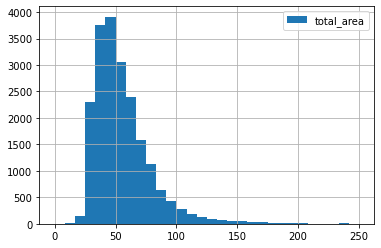

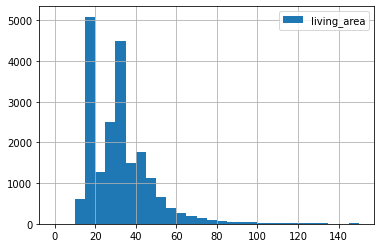

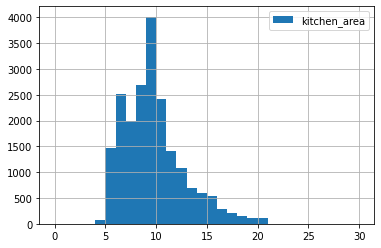

In [56]:
data['total_area'].hist(bins=30, range=(0, 250), legend='total_area')
plt.show()

data['living_area'].hist(bins=30, range=(0, 150), legend='living_area')
plt.show()

data['kitchen_area'].hist(bins=30, range=(0, 30), legend='kitchen_area')
plt.show()

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Здорово, что используешь метод range() для определения пиковых значений
</div>

Хорошие данные, на мой взгляд, есть конечно выбросы, но они логически объяснимы. 

в Площади кухни 2 пика - 6кв.м и 9кв.м. Так оно и есть, первое это хрущевки, которых еще много, а второе - современные дома 80-2000-х годов стандартной планировки.

в Жилой площади тоже 2 пика - 16кв.м и 33кв.м. 16 - это жилая площадь 1кк, однушек на рынке недвижимости у нас в принципе больше всего. 33кв.м. - жилаю площадь стандартной 2кк, двушки - вторая категория квартир по популярности и количеству на рынке.

Общая площадь - по сути это жилая площадь + кухня + некая дельта(санузел, коридоры и пр.). И логичным образом общая площадь скрадывает пики своих отдельных слагаемых. 

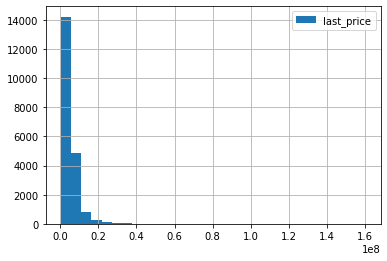

In [57]:
data['last_price'].hist(bins=30, legend='last_price')
plt.show()

Видимо, очень большой разброс, тут даже не видно ничего. Посмотрим макс и мин значение, и отрубим хвост. Иначе далее, когда мы будем смотреть корреляции, он нам будет мешать.

In [58]:
data['last_price'].describe()

count    2.038600e+04
mean     5.534245e+06
std      4.974667e+06
min      4.300000e+05
25%      3.350000e+06
50%      4.500000e+06
75%      6.280000e+06
max      1.599840e+08
Name: last_price, dtype: float64

In [59]:
# цена в диапазоне от 430 000 до 160 млн руб. Исходя из графика, отрежем все, что выше 40 млн
data = data.query('last_price < 40000000')
data['last_price'].describe()

count    2.033700e+04
mean     5.387631e+06
std      3.724058e+06
min      4.300000e+05
25%      3.350000e+06
50%      4.490000e+06
75%      6.250000e+06
max      3.999000e+07
Name: last_price, dtype: float64

[ 1  2  3  4  6  5  0 11  7 10  8  9]


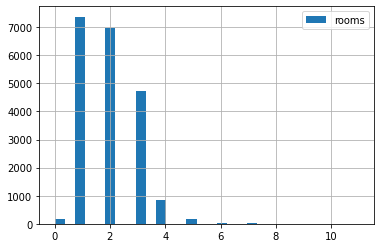

In [60]:
print(data['rooms'].unique())
data['rooms'].hist(bins=30, legend='rooms')
plt.show()

0 комнат в природе не бывает, 6 и более комнат очень редкие значения, вызывающие большие сомнения в своей правдоподобности. Т.к. количество таких объектов невелико, спокойно отрежем лишнее

In [61]:
data = data.query('1 <= rooms < 6')

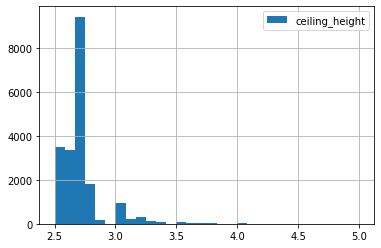

array([2.7, 2.5, 2.6, 3. , 2.8, 2.9, 3.2, 3.4, 4.2, 4. , 3.1, 3.5, 3.3,
       3.6, 3.8, 5. , 4.1, 3.7, 4.8, 4.5, 3.9, 4.4, 4.3])

In [62]:
data['ceiling_height'].hist(bins=30, legend='ceiling_height')
plt.show()
data['ceiling_height'].unique()

С высотой потолков мы уже занимались на этапе предобработки данных. Оставим как есть

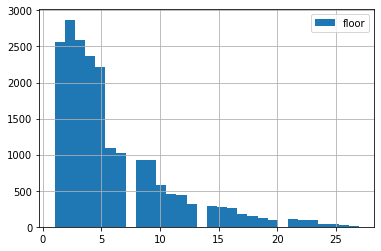

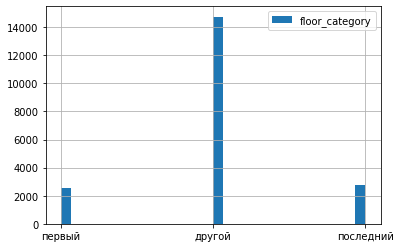

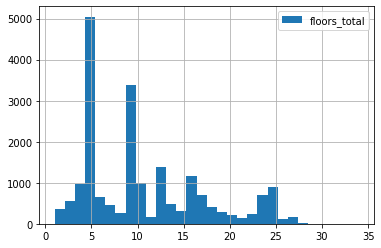

[ 1  5  6 22 26  7  3  4  2  8 11 15 18  9 13 10 19 16 20 27 17 14 12 24
 21 23 25]
['первый' 'другой' 'последний']
[11 12 26 24 27  9  5  6 14 16 25  3 23 17 19 18 22  4 10  7 13 15  2  8
 28 21 20 34  1 29]


In [63]:
# посмотрим все данные, связанные с этажами
data['floor'].hist(bins=30, legend='floor')
plt.show()
data['floor_category'].hist(bins=30, legend='floor_category')
plt.show()
data['floors_total'].hist(bins=30, legend='floors_total')
plt.show()
print(data['floor'].unique())
print(data['floor_category'].unique())
print(data['floors_total'].unique())

Тут почти все нормально, на мой взгляд. Выбросы в этажах мы обрезали ранее. А категория этажей логично отражает реальность: первых и последних этажей мало, других - много. Можно еще подрезать общее количество этажей,т.к. макс этаж в уникальных значениях floor - 27.

In [64]:
data = data.query('floors_total < 27')

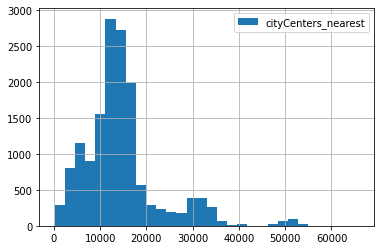

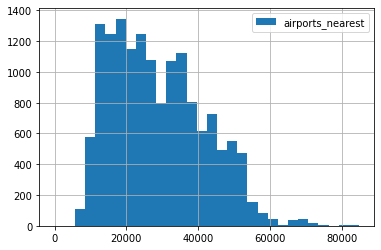

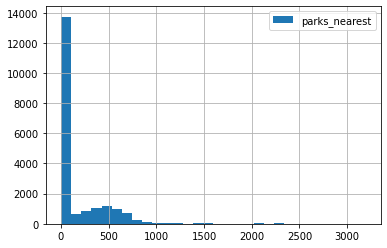

In [65]:
# расстояние до центра города в метрах;
data['cityCenters_nearest'].hist(bins=30, legend='cityCenters_nearest')
plt.show()
# расстояние до ближайшего аэропорта;
data['airports_nearest'].hist(bins=30, legend='airports_nearest')
plt.show()
# расстояние до ближайшего парка;
data['parks_nearest'].hist(bins=30, legend='parks_nearest')
plt.show()

Расстоянием до центра города и до ближайшего аэропорвта мы занимались на этапе предобработки. Гистограммы нормальные, с учетом областных объектов небольшие кучные выбросы на высоких значениях вполне понятны.

Смущает 0м в расстоянии до парка. Но вспомним, что на этапе предобработки мы так заменили пропуски, которые предположительно означают, что парка поблизости просто нет.

In [66]:
data['parks_nearest'].value_counts()

0       13363
441        49
456        32
458        26
392        26
        ...  
1564        1
69          1
53          1
1620        1
1951        1
Name: parks_nearest, Length: 968, dtype: int64

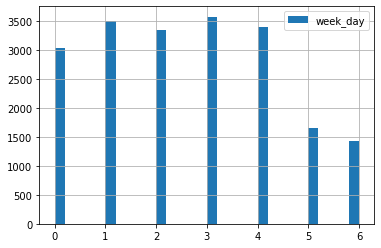

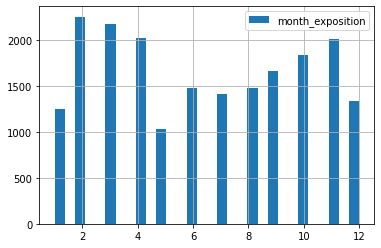

[1 0 3 6 5 4 2]


array([12,  9, 11,  4,  2,  8,  6,  7,  1,  3, 10,  5])

In [67]:
data['week_day'].hist(bins=30, legend='days_exposition')
plt.show()
data['month_exposition'].hist(bins=30, legend='month_exposition')
plt.show()
print(data['week_day'].unique())
data['month_exposition'].unique()

Тут все в норме. 7 дней недели - от 0 до 6 и 12 месяцев. Интересно отметить, что больше всего квартр выставляется на продажу в феврале-марте и в будни (со вторника по пятницу). Что вполне объяснимо: после мертвого января и до дачного сезона собственники занимаются куплей-продажей. Осень - также хороший сезон для недвижимости. Ну а будни - время для активных действий, в отличие от выходных, которые хочется освободить для отдыха.

Изучим, как быстро продавались квартиры (столбец days_exposition). 

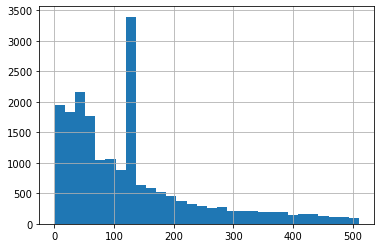

count    19911.000000
mean       127.090503
std        111.686709
min          1.000000
25%         45.000000
50%        105.000000
75%        160.000000
max        510.000000
Name: days_exposition, dtype: float64

In [68]:
#Построим гистограмму, посчитаем среднее и медиану.
data['days_exposition'].hist(bins=30)
plt.show()
data['days_exposition'].describe()


Получается, что продажа занимает в среднем от 105 до 127 дней, это 3,5 - 4 мес. Да, на практике так и есть.

Быстрыми продажами можно считать те, которые в первом квартиле- от 1 до 45 дней, т.е. до 1,5 мес. 

Долгими - все, что больше 3 квартиля, от 5 мес (160 дней).

Нереально долгие продажи мы отсекли на этапе предобработки, оставив в рассмотрении продажи до 1,5 лет.

**Изучим, какие факторы больше всего влияют на общую (полную) стоимость объекта.** Для этого рассмотрим, зависит ли цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

Вместо last_ptice в некоторых случаях думаю правильным будет рассматривать ее производную - стоимость кв метра price_metr

0.7501588714465985


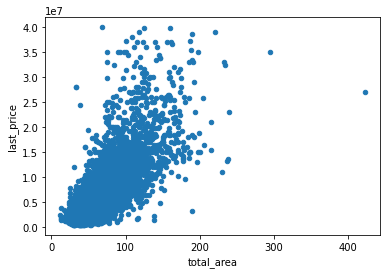

In [69]:
# построим диаграммы рассеивания и почитаем коэффициенты корреляции
# цена от общей площади
data.plot(x='total_area', y='last_price', kind='scatter')
print(data['total_area'].corr(data['last_price'])) 

Да, зависит! Чем больше площадь квартиры, тем выше цена. Это очевидно с точки зрения здравого смысла, хорошо видно на диаграмме. И коэффициент корреляции 0,7 говорит о наличии линейной зависимости.

0.6063051690671623


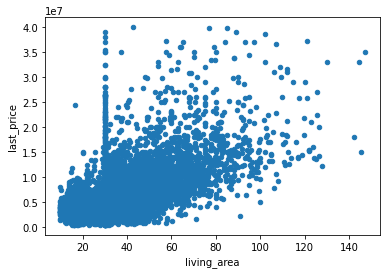

In [70]:
# цена от жилой площади
data.plot(x='living_area', y='last_price', kind='scatter')
print(data['living_area'].corr(data['last_price'])) 

Коэф корр 0,6. По сравнению с общей площадью, линейная зависимость чуть меньше, но есть! Это и понятно, жилая площадь - часть общей.

0.4700733898003027


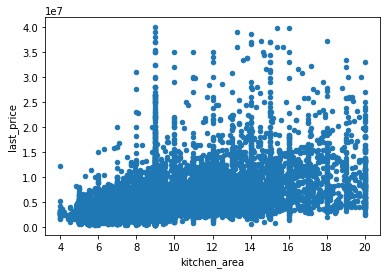

In [71]:
# цена от площади кухни 
data.plot(x='kitchen_area', y='last_price', kind='scatter')
print(data['kitchen_area'].corr(data['last_price'])) 

Линейным образом не зависит. И то верно, на кухне, какая бы она большая ни была, жить не очень удобно

0.458932775720777


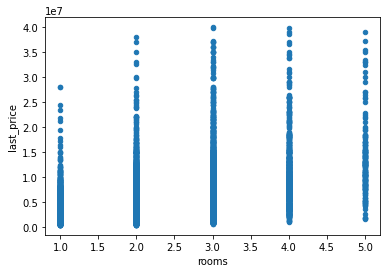

In [72]:
# цена от количества комнат
data.plot(x='rooms', y='last_price', kind='scatter')
print(data['rooms'].corr(data['last_price'])) 

Линейной зависимости нет, оно и понятно. Комнат может быть много и маленьких, или одна-две и огромные. И другие факторы очень могут влиять, например локация.

<AxesSubplot:xlabel='floor_category', ylabel='last_price'>

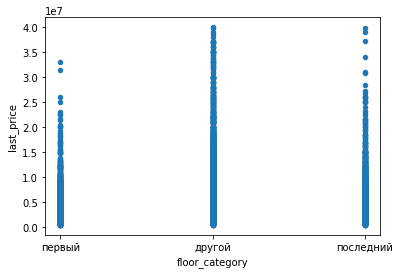

In [73]:
# цена от этажа (первый, последний, другой)
data.plot(x='floor_category', y='last_price', kind='scatter')


Коэффициент корреляции Пирсона не работает с целыми числами и строками. Например мы не можем посчитать зависимость цены от категории этажа (первый, последний, другой).

Попробуем использовать сводную таблицу.

In [74]:
data_pivot = data.pivot_table(index = ['floor_category'], values = 'last_price', aggfunc = 'median')
print(data_pivot)


                last_price
floor_category            
другой             4650000
первый             3850000
последний          4100000


Тут и без Пирсона видно, что дешевле всего стоит первый этаж, чуть дороже последний, а нормальные цены предлагают за другие этажи. Поэтому зависимость от этажа есть, но не линейная, а вот от категории этажа есть линейная зависимость.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Как в песне, "первый и последний этаж не предлагать". Традиционно, квартиры на первом и последнем этажах считаются самыми неудобными для жизни и это отражается на их стоимости.
</div>

-0.009984747887932624


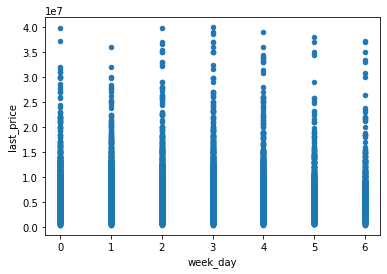

In [75]:
# цена от даты размещения (день недели, месяц, год).
data.plot(x='week_day', y='last_price', kind='scatter')
print(data['week_day'].corr(data['last_price'])) 

И коэффициент и диаграмма рассеивания говорят за то, что зависимости между ценой квартиры и днем размещения нет. И это соответствует здравому смыслу. Каждый день размещаются и дешевые и дорогие квартиры.

0.001983322016593342


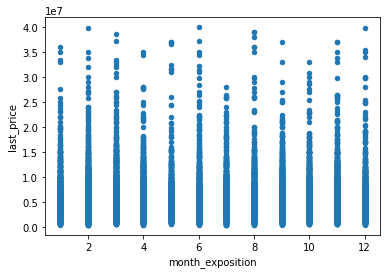

In [76]:
data.plot(x='month_exposition', y='last_price', kind='scatter')
print(data['month_exposition'].corr(data['last_price'])) 

Линейной зависимости нет совсем. Это понятно, рыночные цены меняются годами, но не от месяца к месяцу.

0.0010677618759682892


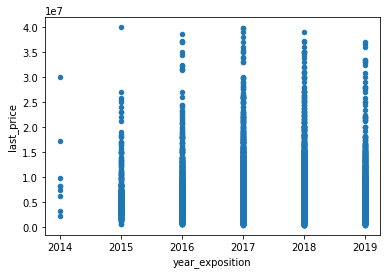

In [77]:
data.plot(x='year_exposition', y='last_price', kind='scatter')
print(data['year_exposition'].corr(data['last_price'])) 

И здесь линейной зависимости нет. Слишком большой разброс объектов по характеристикам, нет категоризации, мы смотрим весь рынок в целом.

In [78]:
# Какие еще зависимости можно выявить? 
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,week_day,month_exposition,year_exposition,cityCenters_nearest_km
total_images,1.000000,0.139083,0.103147,0.082912,0.014640,0.020511,0.095001,0.039664,0.008407,-0.017234,...,0.025437,0.024471,0.004105,0.007036,0.010182,0.126895,-0.009509,0.006739,0.135689,-0.040698
last_price,0.139083,1.000000,0.750159,0.458933,0.382853,0.107488,0.606305,0.090540,0.020142,-0.016545,...,0.273979,0.229423,0.286985,0.176128,0.060955,0.692904,-0.009985,0.001983,0.001068,-0.335421
total_area,0.103147,0.750159,1.000000,0.781689,0.337694,-0.033175,0.865541,-0.022813,0.018320,-0.028592,...,0.143794,0.117776,0.167201,0.090334,0.101704,0.126943,-0.009803,0.013033,-0.047903,-0.200757
rooms,0.082912,0.458933,0.781689,1.000000,0.158085,-0.221019,0.839249,-0.164215,-0.006483,-0.025035,...,0.098673,0.064484,0.082621,0.044684,0.081183,-0.082669,-0.002157,0.003399,-0.028092,-0.139135
ceiling_height,0.014640,0.382853,0.337694,0.158085,1.000000,-0.040196,0.294564,-0.024418,0.053102,0.001752,...,0.203719,0.111303,0.201478,0.080854,0.054367,0.254840,-0.012658,0.000634,-0.059101,-0.272701
floors_total,0.020511,0.107488,-0.033175,-0.221019,-0.040196,1.000000,-0.158793,0.670161,-0.028030,0.019316,...,-0.136791,-0.047610,-0.042792,0.037576,-0.047600,0.267672,0.012784,0.015955,-0.006567,-0.018452
living_area,0.095001,0.606305,0.865541,0.839249,0.294564,-0.158793,1.000000,-0.112803,0.010838,-0.020033,...,0.151444,0.097024,0.139402,0.074405,0.094903,0.040588,-0.009025,-0.000871,-0.036718,-0.189967
floor,0.039664,0.090540,-0.022813,-0.164215,-0.024418,0.670161,-0.112803,1.000000,-0.018921,0.013615,...,-0.091611,-0.028307,-0.023476,0.029880,-0.040363,0.204258,0.008807,0.020055,-0.001477,-0.009846
is_apartment,0.008407,0.020142,0.018320,-0.006483,0.053102,-0.028030,0.010838,-0.018921,1.000000,-0.000898,...,0.009344,-0.015347,0.015530,0.018147,-0.008474,0.016736,-0.016720,-0.010008,0.023435,0.015815
studio,-0.017234,-0.016545,-0.028592,-0.025035,0.001752,0.019316,-0.020033,0.013615,-0.000898,1.000000,...,-0.008505,-0.010292,-0.005214,-0.004726,-0.011081,0.003842,-0.003999,-0.008799,-0.040255,-0.001693


Можно утверждать о существовании линейной зависимости 

общей площади от количества комнат: corr=0.78

жилой площади от количества комнат: corr=0,84

Но это все очевидные вещи)

**Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**

In [79]:
# сделаем сводную таблицу
top_locality = data.pivot_table(index = 'locality_name', values = 'price_metr', aggfunc=['count', 'mean']) 
print(top_locality)

# переименуем столбцы и отсортируем
top_locality.columns=('count', 'mean_price')
top_locality.sort_values('count', ascending = False).head(10)

                     count          mean
                price_metr    price_metr
locality_name                           
   Морозова             17  50732.411765
   Свердлова            33  59625.303030
  Большая Ижора         16  52431.062500
  Будогощь               4  31184.250000
  Важины                 6  20683.833333
...                    ...           ...
Сосновый Бор            80  75855.062500
Сясьстрой               22  34080.454545
Тихвин                  46  39926.913043
Тосно                   89  59358.685393
Шлиссельбург            51  59016.470588

[308 rows x 2 columns]


,count,mean_price
locality_name,,
Санкт-Петербург,13014,109621.864684
Мурино,406,85358.371921
Шушары,402,78392.519900
Всеволожск,338,68548.109467
Колпино,309,75072.928803
Пушкин,306,100865.029412
Гатчина,269,68694.955390
Парголово,248,88820.520161
Кудрово,235,93288.672340


**Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

In [80]:
# во всей базе данных
top_locality.query('mean_price==mean_price.max() or mean_price==mean_price.min()')

,count,mean_price
locality_name,,
Лисий Нос,2,113728.0
Старополье,3,11206.0


In [81]:
# в первой десятке
top_locality.sort_values('count', ascending = False).head(10)\
.query('mean_price==mean_price.max() or mean_price==mean_price.min()')

,count,mean_price
locality_name,,
Санкт-Петербург,13014,109621.864684
Выборг,210,58151.366667


**Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра.**

In [82]:
# выбираем Питер
data_spb = data[data['locality_name']=="Санкт-Петербург"]

# делаем сводную таблицу с километрами и ценой за квадратный метр, так будет нагляднее, чем нули в миллионах считать
spb_place = data_spb.pivot_table(index='cityCenters_nearest_km', values='price_metr')
spb_place

,price_metr
cityCenters_nearest_km,
0.0,149701.928571
1.0,150518.629310
2.0,132293.308824
3.0,118030.605578
4.0,123100.440994
5.0,131189.868217
6.0,131605.620455
7.0,134240.186916
8.0,120815.454741


**Опишите, как стоимость объектов зависит от расстояния до центра города.**

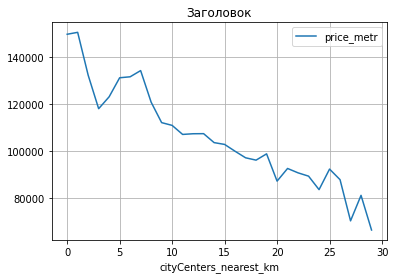

In [83]:
# построим график 
spb_place.plot(grid = True, title = 'Заголовок');

Вывод: в целом, чем ближе к центру города, тем выше цена квадратного метра

**Промежуточный вывод:**

В ходе исследования были визуализированы взаимосвязи между парами значений во всем объеме данных и посчитаны коэффициенты корреляции.

На основании этих данных были выявлены некоторые зависимости, отвечающие на основной вопрос нашего исследования - какие факторы
влияют на цену квартиры при продаже.

Кроме того, определены населенные пункты с самой высокой и самой низкой стоимостью квадратного метра. Составлен рейтинг топ-10 локаций
с наибольшим числом объявлений и описана ситуация с ценами внутри этого рейтинга.

Также на основе данных и графика показано, как стоимость объектов меняется в зависимости от расстояния до центра города.

### Общий вывод

Данные о продаже квартир в Санкт-Петербурге и Ленинградской области были обработаны и изучены.

В ходе изучения данных и были выявлены следующие закономерности:

- Продажа квартиры занимает в среднем от 105 до 127 дней, это 3,5 - 4 мес. 
Быстрыми продажами можно считать те, которые продаются в течение 1,5 мес.
Долгими - все, что висят в продаже свыше 5 мес (160 дней).

- Больше всего квартр выставляется на продажу в феврале-марте и в будни (со вторника по пятницу). 

- Больше всего влияют на общую (полную) стоимость объекта общая и жилая площадь. Чем они больше, тем выше цена.

- Наиболее конкурентный рынок (наибольшее количество объявлений о продаже квартир за исследуемый период) в населенных пунктах:
Санкт-Петербург, Мурино, Шушары, Всеволожск, Колпино, Пушкин, Гатчина, Парголово, Кудрово, Выборг. Среди них в Выборге - самые дешевые квартиры, в Питере - самые дорогие.

- Чем ближе к центру города, тем выше цена квадратного метра 

По качеству данных есть следующие рекомендации:
Пропуски в kitchen_area дублируют пропуски в living_area. Похоже на технический сбой при выгрузке данных.


**Чтобы достичь поставленных целей, исследование проводилось в 7 этапов:**

* общий обзор данных

* предобработка данных

* расчеты и добавление реультатов в таблицу

* проведение анализа для Ленинградской области

* проведение анализа для Санкт-Петербурга

* определение факторов, влияющих на ценообразование стоимости квартир

* написание общего вывода
